In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys

from smyleutils import averaging_utils as avg
from smyleutils import qboplot_utils as qbo
from smyleutils import colorbar_utils as cbars
from smyleutils import bootstrap_utils as boot
from smyleutils import mapplot_utils as mymaps
from smyleutils import zmplot_utils as zmplot
from smyleutils import linfit_utils as linfit
from smyleutils import patterncor_utils as patterncor
from smyleutils import histoplot_utils as histo
import cartopy.crs as ccrs
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [2]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

### Read in the QBO data

In [3]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc').Uzm
uzm_era5_nov_tr = avg.cosweightlat(uzm_era5_nov,-5,5).load()
uqbo = uzm_era5_nov_tr.interp(level=60.).sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uqbo = uqbo - uqbo.mean('init_year')
uqbo_std = uqbo.std('init_year')

DataArrayWeighted with weights along dimensions: lat


### Read in the Pacific zonal means

In [4]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/pacific_zmU/"
l83_zm = xr.open_dataset(basepath+'U_pacific_L83_init11.nc').U
l83_zm['pre'] = l83_zm.pre / 100.
era5_zm = xr.open_dataset(basepath+'U_pacific_ERA5_init11.nc').ua
jra3q_zm = xr.open_dataset(basepath+'U_pacific_JRA3Q_init11.nc').ua

# interpolate jra3q onto the same latitude grid as the other datasets
jra3q_zm = jra3q_zm.interp(lat=l83_zm.lat)

# Make sure latitudes are consistent
era5_zm['lat'] = l83_zm.lat

# interpolate ERA5 and JRA3Q onto the same pressure levels as the model
jra3q_zm = jra3q_zm.interp(pre=l83_zm.pre)
era5_zm = era5_zm.interp(pre=l83_zm.pre)

### Calculate the DJF average

In [5]:
era5_zm_djf = era5_zm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
jra3q_zm_djf = jra3q_zm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')
l83_zm_djf = l83_zm.sel(time=slice("1970-12-01","1971-02-28")).mean('time')

### Calculate the ensemble mean

In [6]:
l83_zm_djf_em = l83_zm_djf.mean('M').load()
era5_zm_djf = era5_zm_djf.load()
jra3q_zm_djf = jra3q_zm_djf.load()

### Calculate the lead dependent climatology

In [7]:
era5_zm_djf_clim = era5_zm_djf.mean('init_year')
jra3q_zm_djf_clim = jra3q_zm_djf.mean('init_year')
l83_zm_djf_clim = l83_zm_djf_em.mean('init_year')

### Remove the lead dependent climatology

In [8]:
era5_zm_djf_anoms = era5_zm_djf - era5_zm_djf_clim
jra3q_zm_djf_anoms = jra3q_zm_djf - jra3q_zm_djf_clim
l83_zm_djf_anoms = l83_zm_djf - l83_zm_djf_clim

### Calculate the ensemble mean for the models

In [9]:
l83_zm_djf_anoms_em = l83_zm_djf_anoms.mean('M')

### Regress out ENSO based on the observed Nino3.4 index

In [10]:
sst = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SST/SST_ERSSTv5_mon_init11.nc")
sstm = sst.sel(time=slice("1970-11-01","1971-03-31")).mean('time')
nino34 = avg.cosweightlonlat(sstm, 210, 270, -5, 5)
nino34 = nino34.ssta - nino34.ssta.mean('init_year')

a_era5 = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])
b_era5 = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])

a_jra3q = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])
b_jra3q = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])

a_l83 = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])
b_l83 = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])


for ilat in np.arange(0,era5_zm_djf_anoms.lat.size,1):
    for ip in np.arange(0,era5_zm_djf_anoms.pre.size,1):
        at, bt = linfit.linfit_xy(nino34, era5_zm_djf_anoms.isel(pre=ip, lat=ilat))
        a_era5[ip,ilat] = at ; b_era5[ip,ilat] = bt

        at, bt = linfit.linfit_xy(nino34, jra3q_zm_djf_anoms.isel(pre=ip, lat=ilat))
        a_jra3q[ip,ilat] = at ; b_jra3q[ip,ilat] = bt

        at, bt = linfit.linfit_xy(nino34, l83_zm_djf_anoms_em.isel(pre=ip, lat=ilat))
        a_l83[ip,ilat] = at ; b_l83[ip,ilat] = bt

### Set up the arrays with and without ENSO so that both can be tested

In [11]:
era5_withenso = era5_zm_djf_anoms
era5_noenso = era5_zm_djf_anoms - (a_era5 + b_era5*nino34)

jra3q_withenso = jra3q_zm_djf_anoms
jra3q_noenso = jra3q_zm_djf_anoms - (a_jra3q + b_jra3q*nino34)

l83_withenso = l83_zm_djf_anoms
l83_noenso = l83_zm_djf_anoms - (a_l83 + b_l83*nino34)

### Get the single member bootstrapped samples for L83

In [12]:
boot_l83_withenso = [] 
boot_l83_noenso = []
for iyear in np.arange(0,l83_withenso.init_year.size,1):
    bootdat = boot.bootgen(l83_withenso.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l83_withenso.append(bootdat)

    bootdat = boot.bootgen(l83_noenso.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l83_noenso.append(bootdat)

boot_l83_withenso = xr.concat(boot_l83_withenso, dim=l83_withenso.init_year)
boot_l83_noenso = xr.concat(boot_l83_noenso, dim=l83_withenso.init_year)

### Get the westerly and easterly QBO composites

In [13]:
westera5_withenso = era5_withenso.isel(init_year = uqbo.values > uqbo_std.values).mean('init_year').load()
eastera5_withenso = era5_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

westera5_noenso = era5_noenso.isel(init_year = uqbo.values > uqbo_std.values).mean('init_year').load()
eastera5_noenso = era5_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

westjra3q_withenso = jra3q_withenso.isel(init_year = uqbo.values > uqbo_std.values).mean('init_year').load()
eastjra3q_withenso = jra3q_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

westjra3q_noenso = jra3q_noenso.isel(init_year = uqbo.values > uqbo_std.values).mean('init_year').load()
eastjra3q_noenso = jra3q_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

westl83_withenso = l83_withenso.mean('M').isel(init_year = uqbo.values > uqbo_std.values).mean('init_year').load()
eastl83_withenso = l83_withenso.mean('M').isel(init_year = uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

westl83_noenso = l83_noenso.mean('M').isel(init_year = uqbo.values > uqbo_std.values).mean('init_year').load()
eastl83_noenso = l83_noenso.mean('M').isel(init_year = uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

west_boot_l83_withenso = boot_l83_withenso.isel(init_year=uqbo.values > uqbo_std.values).mean('init_year').load()
east_boot_l83_withenso = boot_l83_withenso.isel(init_year=uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

west_boot_l83_noenso = boot_l83_noenso.isel(init_year=uqbo.values > uqbo_std.values).mean('init_year').load()
east_boot_l83_noenso = boot_l83_noenso.isel(init_year=uqbo.values < -1.*uqbo_std.values).mean('init_year').load()

### Get the inputs for the correlation/regression analysis

In [14]:
# Subset the NH below 10 hPa
era5_for_cor_withenso = westera5_withenso.sel(lat=slice(0,90), pre=slice(1000,10)) - eastera5_withenso.sel(lat=slice(0,90), pre=slice(1000,10))
era5_for_cor_noenso = westera5_noenso.sel(lat=slice(0,90), pre=slice(1000,10)) - eastera5_noenso.sel(lat=slice(0,90), pre=slice(1000,10))

jra3q_for_cor_withenso = westjra3q_withenso.sel(lat=slice(0,90), pre=slice(1000,10)) - eastjra3q_withenso.sel(lat=slice(0,90), pre=slice(1000,10))
jra3q_for_cor_noenso = westjra3q_noenso.sel(lat=slice(0,90), pre=slice(1000,10)) - eastjra3q_noenso.sel(lat=slice(0,90), pre=slice(1000,10))

l83_for_cor_withenso = westl83_withenso.sel(lat=slice(0,90), pre=slice(1000,10)) - eastl83_withenso.sel(lat=slice(0,90), pre=slice(1000,10))
l83_for_cor_noenso = westl83_noenso.sel(lat=slice(0,90), pre=slice(1000,10)) - eastl83_noenso.sel(lat=slice(0,90), pre=slice(1000,10))

l83_boot_for_cor_withenso = west_boot_l83_withenso.sel(lat=slice(0,90), pre=slice(1000,10)) - east_boot_l83_withenso.sel(lat=slice(0,90), pre=slice(1000,10))
l83_boot_for_cor_noenso = west_boot_l83_noenso.sel(lat=slice(0,90), pre=slice(1000,10)) - east_boot_l83_noenso.sel(lat=slice(0,90), pre=slice(1000,10))

# Set the QBO box to NaN's
era5_for_cor_withenso = era5_for_cor_withenso.where( ~(( era5_for_cor_withenso.pre < 100) & (era5_for_cor_withenso.lat < 25)), nan)
era5_for_cor_noenso = era5_for_cor_noenso.where( ~(( era5_for_cor_noenso.pre < 100) & (era5_for_cor_noenso.lat < 25)), nan)

jra3q_for_cor_withenso = jra3q_for_cor_withenso.where( ~(( jra3q_for_cor_withenso.pre < 100) & (jra3q_for_cor_withenso.lat < 25)), nan)
jra3q_for_cor_noenso = jra3q_for_cor_noenso.where( ~(( jra3q_for_cor_noenso.pre < 100) & (jra3q_for_cor_noenso.lat < 25)), nan)

l83_for_cor_withenso = l83_for_cor_withenso.where( ~(( l83_for_cor_withenso.pre < 100) & (l83_for_cor_withenso.lat < 25)), nan)
l83_for_cor_noenso = l83_for_cor_noenso.where( ~(( l83_for_cor_noenso.pre < 100) & (l83_for_cor_noenso.lat < 25)), nan)

l83_boot_for_cor_withenso = l83_boot_for_cor_withenso.where( ~(( l83_boot_for_cor_withenso.pre < 100) & (l83_boot_for_cor_withenso.lat < 25)), nan)
l83_boot_for_cor_noenso = l83_boot_for_cor_noenso.where( ~(( l83_boot_for_cor_noenso.pre < 100) & (l83_boot_for_cor_noenso.lat < 25)), nan)

# Stack arrays and drop nans
era5_for_cor_withenso_stack = era5_for_cor_withenso.stack(z=('pre','lat')).dropna('z')
era5_for_cor_noenso_stack = era5_for_cor_noenso.stack(z=('pre','lat')).dropna('z')

jra3q_for_cor_withenso_stack = jra3q_for_cor_withenso.stack(z=('pre','lat')).dropna('z')
jra3q_for_cor_noenso_stack = jra3q_for_cor_noenso.stack(z=('pre','lat')).dropna('z')

l83_for_cor_withenso_stack = l83_for_cor_withenso.stack(z=('pre','lat')).dropna('z')
l83_for_cor_noenso_stack = l83_for_cor_noenso.stack(z=('pre','lat')).dropna('z')

l83_boot_for_cor_withenso_stack = l83_boot_for_cor_withenso.stack(z=('pre','lat')).dropna('z')
l83_boot_for_cor_noenso_stack = l83_boot_for_cor_noenso.stack(z=('pre','lat')).dropna('z')

### Compute the area weighted pattern correlation and pattern regressions

In [15]:
w_stack = (era5_for_cor_withenso_stack*0 + 1) * np.cos(np.deg2rad(era5_for_cor_withenso_stack.lat))
w = (era5_for_cor_withenso*0 + 1) * np.cos(np.deg2rad(era5_for_cor_withenso.lat))

aera5_withenso, bera5_withenso = patterncor.weightedpatternregression(l83_for_cor_withenso_stack, era5_for_cor_withenso_stack, w_stack)
aera5_noenso, bera5_noenso = patterncor.weightedpatternregression(l83_for_cor_noenso_stack, era5_for_cor_noenso_stack, w_stack)

ajra3q_withenso, bjra3q_withenso = patterncor.weightedpatternregression(l83_for_cor_withenso_stack, jra3q_for_cor_withenso_stack, w_stack)
ajra3q_noenso, bjra3q_noenso = patterncor.weightedpatternregression(l83_for_cor_noenso_stack, jra3q_for_cor_noenso_stack, w_stack)

cor_era5_withenso = patterncor.weightedspatialcor(era5_for_cor_withenso, l83_for_cor_withenso, w, londim='pre', latdim='lat')
cor_era5_noenso = patterncor.weightedspatialcor(era5_for_cor_noenso, l83_for_cor_noenso, w, londim='pre', latdim='lat')

cor_jra3q_withenso = patterncor.weightedspatialcor(jra3q_for_cor_withenso, l83_for_cor_withenso, w, londim='pre', latdim='lat')
cor_jra3q_noenso = patterncor.weightedspatialcor(jra3q_for_cor_noenso, l83_for_cor_noenso, w, londim='pre', latdim='lat')

b_boot_withenso=[] ; cor_boot_withenso=[]
b_boot_noenso=[] ; cor_boot_noenso=[]
for iboot in np.arange(0,l83_boot_for_cor_withenso.iboot.size,1):
    a, b = patterncor.weightedpatternregression(l83_for_cor_withenso_stack, l83_boot_for_cor_withenso_stack.isel(iboot=iboot), w_stack)
    b_boot_withenso.append(b)
    cor_boot_withenso.append(patterncor.weightedspatialcor(l83_for_cor_withenso, l83_boot_for_cor_withenso.isel(iboot=iboot), w, londim='pre', latdim='lat'))

    a, b = patterncor.weightedpatternregression(l83_for_cor_noenso_stack, l83_boot_for_cor_noenso_stack.isel(iboot=iboot), w_stack)
    b_boot_noenso.append(b)
    cor_boot_noenso.append(patterncor.weightedspatialcor(l83_for_cor_noenso, l83_boot_for_cor_noenso.isel(iboot=iboot), w, londim='pre', latdim='lat'))

b_boot_withenso = np.array(b_boot_withenso)
b_boot_noenso = np.array(b_boot_noenso)
cor_boot_withenso = xr.concat(cor_boot_withenso, dim='iboot')
cor_boot_noenso = xr.concat(cor_boot_noenso, dim='iboot')

### Plot with ENSO left in (not saving this one - just testing)

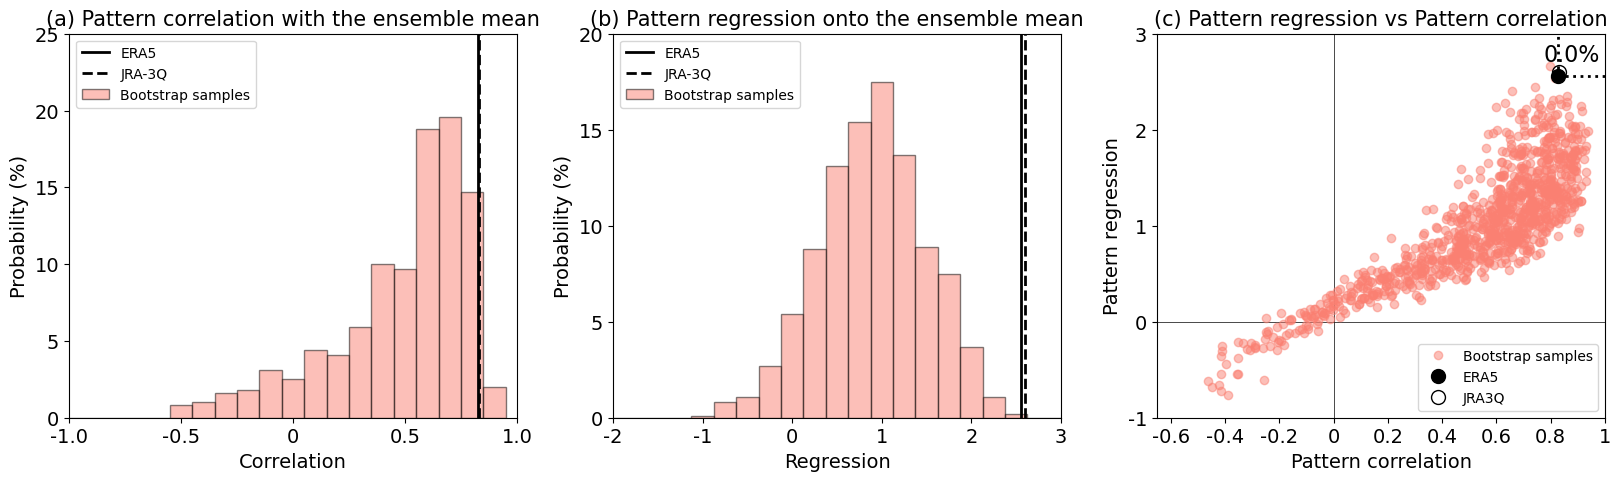

In [16]:
fig = plt.figure(figsize=(16,16))

ax = histo.plothisto(fig, cor_boot_withenso, np.arange(-1,1+0.1,0.1), 0.02,0.3,0.76,1,percent=True, label='Bootstrap samples', color='salmon', alpha=0.5)
ax.set_title('(a) Pattern correlation with the ensemble mean', fontsize=15)
ax.set_ylabel('Probability (%)', fontsize=14)
ax.set_xlabel('Correlation', fontsize=14)
ax.set_ylim(0,25)
ax.set_xlim(-1,1)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_xticklabels(['-1.0','-0.5','0','0.5','1.0'], fontsize=14)
ax.set_yticks([0,5,10,15,20,25])
ax.set_yticklabels(['0','5','10','15','20','25'], fontsize=14)
ax.plot([cor_era5_withenso, cor_era5_withenso],[0,25],color='black', linewidth=2, label='ERA5')
ax.plot([cor_jra3q_withenso, cor_jra3q_withenso],[0,25], color='black', linestyle='dashed', linewidth=2, label='JRA-3Q')
ax.legend()


ax = histo.plothisto(fig, b_boot_withenso, np.arange(-2,4+0.25,0.25),0.36,0.64,0.76,1,percent=True, label='Bootstrap samples', color='salmon', alpha=0.5)
ax.plot([bera5_withenso, bera5_withenso],[0,20], color='black', linewidth=2, label='ERA5')
ax.plot([bjra3q_withenso, bjra3q_withenso],[0,20], color='black', linestyle='dashed', linewidth=2, label='JRA-3Q')
ax.set_ylim(0,20)
ax.set_xlim(-2,3)
ax.set_xticks([-2,-1,0,1,2,3])
ax.set_xticklabels(['-2','-1','0','1','2','3'], fontsize=14)
ax.set_xlabel('Regression', fontsize=14)
ax.set_yticks([0,5,10,15,20])
ax.set_yticklabels(['0','5','10','15','20'], fontsize=14)
ax.set_ylabel('Probability (%)', fontsize=14)
ax.set_title('(b) Pattern regression onto the ensemble mean', fontsize=15)
ax.legend()

ax = fig.add_axes([0.7,0.76,0.28,0.24])
ax.set_xlim(-0.65, 1)
ax.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax.set_title('(c) Pattern regression vs Pattern correlation', fontsize=15)
ax.set_xlabel('Pattern correlation', fontsize=14)
ax.set_ylim(-1,3)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(['-1','0','1','2','3'], fontsize=14)
ax.set_ylabel('Pattern regression', fontsize=14)
ax.plot([-0.65,1],[0,0], color='black', linewidth=0.5)
ax.plot([0,0],[-1,3], color='black', linewidth=0.5)

ax.plot(cor_boot_withenso, b_boot_withenso, "o", color='salmon', label='Bootstrap samples', alpha=0.5)
ax.plot(cor_era5_withenso, bera5_withenso, "o", color='black', markersize=10, label='ERA5')
ax.plot(cor_jra3q_withenso, bjra3q_withenso, "o", markerfacecolor='None', markeredgecolor='black', markersize=10, label='JRA3Q')

ax.plot([cor_era5_withenso,1],[bera5_withenso,bera5_withenso], color='black', linestyle='dotted', linewidth=2)
ax.plot([cor_era5_withenso,cor_era5_withenso],[bera5_withenso,3], color='black', linestyle='dotted', linewidth=2)

bootoutside = cor_boot_withenso*0 + 1
bootoutside = bootoutside.where( (cor_boot_withenso > cor_era5_withenso) & (b_boot_withenso > bera5_withenso), drop=True)
bootoutside_per = (bootoutside.sum() / cor_boot_withenso.size) * 100.
ax.text(0.98, 2.9, str(bootoutside_per.values)+"%", ha='right', va='top', fontsize=16)

ax.legend()



### Plot with ENSO regressed out.  Saving this one

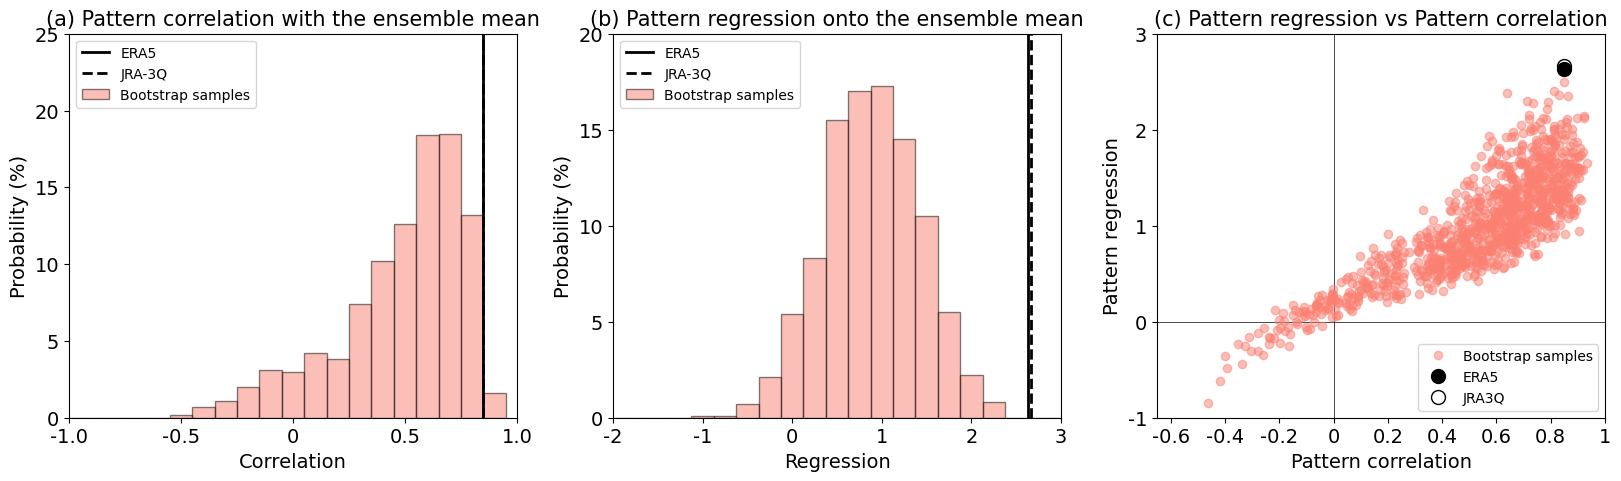

In [18]:
fig = plt.figure(figsize=(16,16))

ax = histo.plothisto(fig, cor_boot_noenso, np.arange(-1,1+0.1,0.1), 0.02,0.3,0.76,1,percent=True, label='Bootstrap samples', color='salmon', alpha=0.5)
ax.set_title('(a) Pattern correlation with the ensemble mean', fontsize=15)
ax.set_ylabel('Probability (%)', fontsize=14)
ax.set_xlabel('Correlation', fontsize=14)
ax.set_ylim(0,25)
ax.set_xlim(-1,1)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_xticklabels(['-1.0','-0.5','0','0.5','1.0'], fontsize=14)
ax.set_yticks([0,5,10,15,20,25])
ax.set_yticklabels(['0','5','10','15','20','25'], fontsize=14)
ax.plot([cor_era5_noenso, cor_era5_noenso],[0,25],color='black', linewidth=2, label='ERA5')
ax.plot([cor_jra3q_noenso, cor_jra3q_noenso],[0,25], color='black', linestyle='dashed', linewidth=2, label='JRA-3Q')
ax.legend()


ax = histo.plothisto(fig, b_boot_noenso, np.arange(-2,4+0.25,0.25),0.36,0.64,0.76,1,percent=True, label='Bootstrap samples', color='salmon', alpha=0.5)
ax.plot([bera5_noenso, bera5_noenso],[0,20], color='black', linewidth=2, label='ERA5')
ax.plot([bjra3q_noenso, bjra3q_noenso],[0,20], color='black', linestyle='dashed', linewidth=2, label='JRA-3Q')
ax.set_ylim(0,20)
ax.set_xlim(-2,3)
ax.set_xticks([-2,-1,0,1,2,3])
ax.set_xticklabels(['-2','-1','0','1','2','3'], fontsize=14)
ax.set_xlabel('Regression', fontsize=14)
ax.set_yticks([0,5,10,15,20])
ax.set_yticklabels(['0','5','10','15','20'], fontsize=14)
ax.set_ylabel('Probability (%)', fontsize=14)
ax.set_title('(b) Pattern regression onto the ensemble mean', fontsize=15)
ax.legend()

ax = fig.add_axes([0.7,0.76,0.28,0.24])
ax.set_xlim(-0.65, 1)
ax.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax.set_title('(c) Pattern regression vs Pattern correlation', fontsize=15)
ax.set_xlabel('Pattern correlation', fontsize=14)
ax.set_ylim(-1,3.)
ax.set_yticks([-1,0,1,2,3])
ax.set_yticklabels(['-1','0','1','2','3'], fontsize=14)
ax.set_ylabel('Pattern regression', fontsize=14)
ax.plot([-0.65,1],[0,0], color='black', linewidth=0.5)
ax.plot([0,0],[-1,3.], color='black', linewidth=0.5)

ax.plot(cor_boot_noenso, b_boot_noenso, "o", color='salmon', label='Bootstrap samples', alpha=0.5)
ax.plot(cor_era5_noenso, bera5_noenso, "o", color='black', markersize=10, label='ERA5')
ax.plot(cor_jra3q_noenso, bjra3q_noenso, "o", markerfacecolor='None', markeredgecolor='black', markersize=10, label='JRA3Q')

#ax.plot([cor_era5_noenso,1],[bera5_noenso,bera5_noenso], color='black', linestyle='dotted', linewidth=2)
#ax.plot([cor_era5_noenso,cor_era5_noenso],[bera5_noenso,3.], color='black', linestyle='dotted', linewidth=2)

bootoutside = cor_boot_noenso*0 + 1
bootoutside = bootoutside.where( (cor_boot_noenso > cor_era5_noenso) & (b_boot_noenso > bera5_noenso), drop=True)
bootoutside_per = (bootoutside.sum() / cor_boot_noenso.size) * 100.
#ax.text(0.99, 3.2, str(bootoutside_per.values)+"%", ha='right', va='top', fontsize=14)

ax.legend()

fig.savefig(plotpath+'fig12.png', bbox_inches='tight', facecolor='white')

In [29]:
test = b_boot_withenso[b_boot_withenso > bera5_withenso]

In [23]:
print(bootoutside_per)

<xarray.DataArray ()>
array(0.)
Coordinates:
    isample  int64 0
